In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

from helpers import *
import time

#### Prepare raw data
- Create detect and classify labels 
- Add ID from index for identifying specific wafers

In [2]:
# load data
with open('WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')
raw_data.head()

Raw data shape: (172950, 11)


,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train


In [3]:
# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

# keep only train set
train = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)
print(train.shape)
train.head()

(121065, 14)


,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
1,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
2,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
3,6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8
4,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8


#### Create 224x224 datasets
- waferMap resized to 224x224 --> waferMap224

In [4]:
# resize to 224x224
start = time.time()

def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
train['waferMap224'] = train.waferMap.apply(lambda x: resize(x))

# check that resizing worked
print('Wall time: {:.3f} seconds'.format(time.time() - start))
print(train.waferMap224[0].shape)
print(np.unique(train.waferMap224[0]))

Wall time: 229.945 seconds
(224, 224)
[0 1 2]


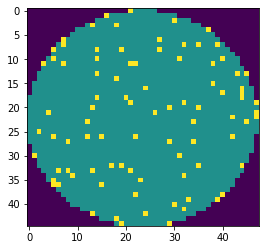

In [5]:
plt.imshow(raw_data.waferMap[0])

##### Randomly undersample none class

In [6]:
# create detund dataset
# make list of none indices
none_df = train[train.detectLabels == 0]
none_list = none_df.index.tolist()
print(f'None count: {len(none_list)}')

# make list of defect indices
def_df = train[train.detectLabels == 1]
def_list = def_df.index.tolist()
print(f'Defect count: {len(def_list)}')

# randomly undersample none list
from random import sample, seed
seed(424)
under_none = sample(none_list, 30000)

# recombine defect indices with undersampled none indices
new_list = sorted(under_none + def_list)
print(f'Undersampled dataset count: {len(new_list)}')

# undersample data
undersampled = train.loc[new_list].reset_index(drop=True)
print(undersampled.shape)
undersampled.head()

None count: 103202
Defect count: 17863
Undersampled dataset count: 47863
(47863, 15)


,ID,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detectLabels,classifyLabels,waferMap224
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0,8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,14.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,15.0,Edge-Loc,3,53,58,"(53, 58)","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,16.0,Loc,5,53,58,"(53, 58)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",train,1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


##### Augment defect classes with random flips and rotations

In [7]:
# create list of indices of each defect type (except none)
# find count of the max class
defects = ['Loc', 'Edge-Loc', 'Center', 'Edge-Ring', 'Scratch', 'Random', 'Near-full', 'Donut']
defect_indices = [[i for i in range(len(undersampled)) if undersampled.failureType.loc[i] == defect] 
                  for defect in defects]
max_count = max([len(def_list) for def_list in defect_indices])

In [8]:
# create list of dfs with augmented samples for each class
new_samples = []
for i in range(8):
    defect = defects[i]
    classLabel = fail_dict[defect]
    labels = defect_indices[i]
    number = max_count - len(labels)
    if number:
        new_df = flip_rotate(undersampled, 'waferMap224', defect, classLabel, labels, number, frac=25)
    else:
        new_df = pd.DataFrame()
    new_samples.append(new_df)
    
    # sanity check
    print(f'Defect to be augmented: {defect} ({len(labels)})')
    print(f'Number of new samples to generate: {number}')
    print(f'Number of new samples generated: {len(new_df)}')
    if len(new_df):
        print(f'Map unique values: {np.unique(new_df.waferMap224[0])}')
    print()

Defect to be augmented: Loc (2515)
Number of new samples to generate: 4261
Number of new samples generated: 4261
Map unique values: [0 1 2]

Defect to be augmented: Edge-Loc (3632)
Number of new samples to generate: 3144
Number of new samples generated: 3144
Map unique values: [0 1 2]

Defect to be augmented: Center (3006)
Number of new samples to generate: 3770
Number of new samples generated: 3770
Map unique values: [0 1 2]

Defect to be augmented: Edge-Ring (6776)
Number of new samples to generate: 0
Number of new samples generated: 0

Defect to be augmented: Scratch (835)
Number of new samples to generate: 5941
Number of new samples generated: 5941
Map unique values: [0 1 2]

Defect to be augmented: Random (606)
Number of new samples to generate: 6170
Number of new samples generated: 6170
Map unique values: [0 1 2]

Defect to be augmented: Near-full (104)
Number of new samples to generate: 6672
Number of new samples generated: 6672
Map unique values: [0 1 2]

Defect to be augmented

In [9]:
# keep only columns needed for modeling
# prepare for joining with new samples
model_data = undersampled[['ID', 'waferMap224', 'failureType', 'classifyLabels']]
model_data.head()

,ID,waferMap224,failureType,classifyLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,0


In [10]:
# join augmented samples to undersampled df
for df in new_samples:
    model_data = pd.concat([model_data, df], ignore_index=True)
    
    # sanity check
    print(len(model_data))
model_data.head()

52124
55268
59038
59038
64979
71149
77821
84208


,ID,waferMap224,failureType,classifyLabels
0,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none,8.0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1.0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1.0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Edge-Loc,1.0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,0.0


In [11]:
# randomly shuffle rows
model_data = model_data.drop('failureType', axis=1)
model_data = model_data.sample(frac=1).reset_index(drop=True)
model_data['classifyLabels'] = model_data.classifyLabels.astype('int')
model_data.head()

,ID,waferMap224,classifyLabels
0,A,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6
1,25977,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,141913,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
3,32792,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8
4,73401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8


##### Generate datasets

In [12]:
# # save dataset with nones undersampled and defects augmented
# # for use in one-step classification
# with open('WM-clean224/WM-clean224-train-all.pkl', "wb") as f:
#     pickle.dump(model_data, f)

In [13]:
classify_data = model_data[model_data.classifyLabels != 8].reset_index(drop=True)
print(classify_data.shape)
classify_data.head()

(54208, 3)


,ID,waferMap224,classifyLabels
0,A,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6
1,25977,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,A,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
3,A,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
4,19339,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3


In [14]:
# # save dataset with augmented defects only
# # for use in classify model
# with open('WM-clean224/WM-clean224-train-clsaug.pkl', "wb") as f:
#     pickle.dump(classify_data, f)